In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from tqdm import tqdm
import seaborn as sns

# SETUP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


In [2]:
dataset_slug = 'adl-project-deep-armocromia'
local_dataset_path = f'/kaggle/input/{dataset_slug}/release'

print(f'Dataset path: {local_dataset_path}')
print(f'Available folders: {os.listdir(local_dataset_path)}')

Dataset path: /kaggle/input/adl-project-deep-armocromia/release
Available folders: ['grok-chat.pdf', 'RGB', 'BM', 'RGB-M', 'annotations.csv']


In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


annotations_df = pd.read_csv('/kaggle/input/adl-project-deep-armocromia/release/annotations.csv')
print(annotations_df.head())
print(f"Dataset shape: {annotations_df.shape}")

season_map = {
    'primavera': 'Spring', 
    'estate': 'Summer', 
    'autunno': 'Autumn', 
    'inverno': 'Winter'
}
annotations_df['class'] = annotations_df['class'].str.lower().map(season_map)

print(annotations_df["class"].unique())
print(annotations_df["sub_class"].unique())
print("\n\n ######## SEASONS AND CHARACTERISTICS (using groupby) ###############")
season_subclasses = annotations_df.groupby('class')['sub_class'].unique()
print(season_subclasses)

     class sub_class partition  celeba                 path_rgb_original  \
0  autunno      deep     train    True  RGB/train/autunno/deep/10306.jpg   
1  autunno      deep     train    True  RGB/train/autunno/deep/10411.jpg   
2  autunno      deep     train    True  RGB/train/autunno/deep/10552.jpg   
3  autunno      deep     train    True  RGB/train/autunno/deep/11174.jpg   
4  autunno      deep     train    True  RGB/train/autunno/deep/11199.jpg   

                      path_rgb_masked                        path_mask  
0  RGB-M/train/autunno/deep/10306.png  BM/train/autunno/deep/10306.png  
1  RGB-M/train/autunno/deep/10411.png  BM/train/autunno/deep/10411.png  
2  RGB-M/train/autunno/deep/10552.png  BM/train/autunno/deep/10552.png  
3  RGB-M/train/autunno/deep/11174.png  BM/train/autunno/deep/11174.png  
4  RGB-M/train/autunno/deep/11199.png  BM/train/autunno/deep/11199.png  
Dataset shape: (4920, 7)
['Autumn' 'Summer' 'Winter' 'Spring']
['deep' 'soft' 'warm' 'cool' 'light' 'brig

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

season_le = LabelEncoder()
annotations_df['season_label'] = season_le.fit_transform(annotations_df['class'])

subclass_le = LabelEncoder()
annotations_df['subclass_label'] = subclass_le.fit_transform(annotations_df['sub_class'])

season_labels = to_categorical(annotations_df['season_label'])
subclass_labels = to_categorical(annotations_df['subclass_label'])

print("Season classes:", season_le.classes_)
print("Subclass classes:", subclass_le.classes_)

annotations_df.head()

2025-11-03 16:14:33.186448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762186473.349765      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762186473.399367      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Season classes: ['Autumn' 'Spring' 'Summer' 'Winter']
Subclass classes: ['bright' 'cool' 'deep' 'light' 'soft' 'warm']


,class,sub_class,partition,celeba,path_rgb_original,path_rgb_masked,path_mask,season_label,subclass_label
0,Autumn,deep,train,True,RGB/train/autunno/deep/10306.jpg,RGB-M/train/autunno/deep/10306.png,BM/train/autunno/deep/10306.png,0,2
1,Autumn,deep,train,True,RGB/train/autunno/deep/10411.jpg,RGB-M/train/autunno/deep/10411.png,BM/train/autunno/deep/10411.png,0,2
2,Autumn,deep,train,True,RGB/train/autunno/deep/10552.jpg,RGB-M/train/autunno/deep/10552.png,BM/train/autunno/deep/10552.png,0,2
3,Autumn,deep,train,True,RGB/train/autunno/deep/11174.jpg,RGB-M/train/autunno/deep/11174.png,BM/train/autunno/deep/11174.png,0,2
4,Autumn,deep,train,True,RGB/train/autunno/deep/11199.jpg,RGB-M/train/autunno/deep/11199.png,BM/train/autunno/deep/11199.png,0,2


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input

local_dataset_path = '/kaggle/input/adl-project-deep-armocromia/release'

def load_masked_image(row, size=(224,224)):
    img_path = os.path.join(local_dataset_path, row['path_rgb_masked'])
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, size)
    return preprocess_input(img.astype(np.float32))

def load_partition_data(partition_name, annotations_df, size=(224,224)):
    images = []
    season_y = []
    subclass_y = []

    df_subset = annotations_df[annotations_df['partition'] == partition_name]
    print(f"Loading {partition_name} images: {len(df_subset)} samples")

    for _, row in df_subset.iterrows():
        img = load_masked_image(row, size)
        if img is not None:
            images.append(img)
            season_y.append(row['season_label'])
            subclass_y.append(row['subclass_label'])

    X = np.array(images, dtype=np.float32)
    y_season = to_categorical(np.array(season_y))
    y_subclass = to_categorical(np.array(subclass_y))

    print(f"{partition_name} -> X: {X.shape}, season_y: {y_season.shape}, subclass_y: {y_subclass.shape}")
    return X, y_season, y_subclass

X_train, y_season_train, y_subclass_train = load_partition_data('train', annotations_df)
X_test, y_season_test, y_subclass_test = load_partition_data('test', annotations_df)


Loading train images: 4008 samples
train -> X: (4008, 224, 224, 3), season_y: (4008, 4), subclass_y: (4008, 6)
Loading test images: 912 samples
test -> X: (912, 224, 224, 3), season_y: (912, 4), subclass_y: (912, 6)


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
n_seasons = y_season_train.shape[1]
n_subclasses = y_subclass_train.shape[1]


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True


inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

season_output = Dense(n_seasons, activation='softmax', name='season_output')(x)
subclass_output = Dense(n_subclasses, activation='softmax', name='subclass_output')(x)

model = Model(inputs=inputs, outputs=[season_output, subclass_output])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'season_output': 'categorical_crossentropy',
        'subclass_output': 'categorical_crossentropy'
    },
    metrics={
        'season_output': 'accuracy',
        'subclass_output': 'accuracy'
    }
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_10[0… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_output       │ (None, 4)         │      5,124 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subclass_output     │ (None, 6)         │      7,686 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 4,020,358 (15.34 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train,
    {'season_output': y_season_train, 'subclass_output': y_subclass_train},
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 3.1465 - season_output_accuracy: 0.3469 - season_output_loss: 1.3695 - subclass_output_accuracy: 0.2557 - subclass_output_loss: 1.7770

E0000 00:00:1762186910.860226     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762186911.045499     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762186911.448752     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762186911.653717     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


126/126 ━━━━━━━━━━━━━━━━━━━━ 124s 358ms/step - loss: 3.1435 - season_output_accuracy: 0.3477 - season_output_loss: 1.3682 - subclass_output_accuracy: 0.2567 - subclass_output_loss: 1.7752 - learning_rate: 1.0000e-04
Epoch 2/25
  1/126 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - loss: 2.6830 - season_output_accuracy: 0.5312 - season_output_loss: 1.1410 - subclass_output_accuracy: 0.3750 - subclass_output_loss: 1.5420

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,season_output_accuracy,season_output_loss,subclass_output_accuracy,subclass_output_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,season_output_accuracy,season_output_loss,subclass_output_accuracy,subclass_output_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 2.4615 - season_output_accuracy: 0.5239 - season_output_loss: 1.0782 - subclass_output_accuracy: 0.4413 - subclass_output_loss: 1.3833 - learning_rate: 1.0000e-04
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 2.1834 - season_output_accuracy: 0.5766 - season_output_loss: 0.9779 - subclass_output_accuracy: 0.5366 - subclass_output_loss: 1.2056 - learning_rate: 1.0000e-04
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 1.9221 - season_output_accuracy: 0.6525 - season_output_loss: 0.8444 - subclass_output_accuracy: 0.5984 - subclass_output_loss: 1.0777 - learning_rate: 1.0000e-04
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 1.6955 - season_output_accuracy: 0.6960 - season_output_loss: 0.7479 - subclass_output_accuracy: 0.6445 - subclass_output_loss: 0.9476 - learning_rate: 1.0000e-04
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 1.4639 - season_output_accuracy: 0.7395 - se

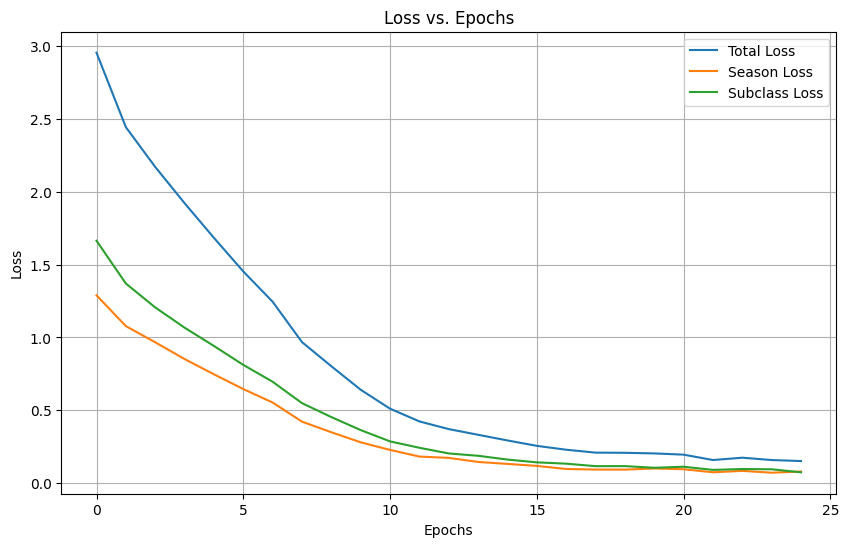

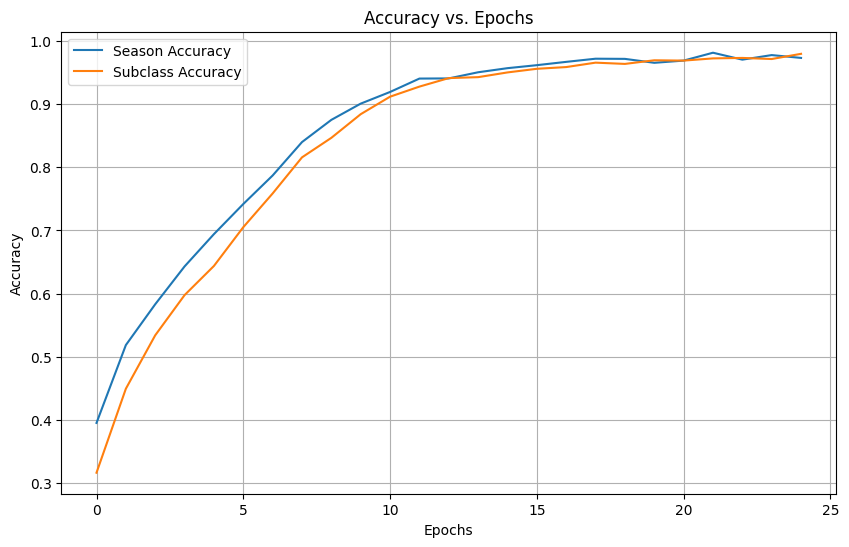

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['season_output_loss'], label='Season Loss')
plt.plot(history.history['subclass_output_loss'], label='Subclass Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
plt.plot(history.history['subclass_output_accuracy'], label='Subclass Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

# --- Predictions ---
season_pred, subclass_pred = model.predict(X_test, verbose=1)

# --- Ground Truth ---
y_season_true = np.argmax(y_season_test, axis=1)
y_subclass_true = np.argmax(y_subclass_test, axis=1)

# --- Top-1 and Top-2 Accuracy (Season) ---
def topk_accuracy(preds, labels, k=1):
    top_k = np.argsort(preds, axis=1)[:, -k:]
    correct = np.any(top_k == labels[:, None], axis=1)
    return np.mean(correct) * 100

top1_acc = topk_accuracy(season_pred, y_season_true, k=1)
top2_acc = topk_accuracy(season_pred, y_season_true, k=2)

# --- Subclass Accuracy ---
season_pred_labels = np.argmax(season_pred, axis=1)
subclass_pred_labels = np.argmax(subclass_pred, axis=1)

season_correct = np.sum(season_pred_labels == y_season_true)
subclass_correct = np.sum(subclass_pred_labels == y_subclass_true)
n_test = y_season_true.shape[0]

season_acc = season_correct / n_test * 100
subclass_acc = subclass_correct / n_test * 100

# --- Confusion Matrix & Per-Class Accuracy ---
class_names = ['Winter', 'Autumn', 'Summer', 'Spring']  # adjust if different
cm = confusion_matrix(y_season_true, season_pred_labels)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

conf_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion Matrix:\n", conf_df)
print("\nPer-Class Accuracy:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {cm[i,i]} correct / {cm.sum(axis=1)[i]} total → {per_class_acc[i]*100:.2f}%")

# --- Summary Metrics for README ---
print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-2 Accuracy: {top2_acc:.2f}%")
print(f"Season Accuracy: {season_acc:.2f}%")
print(f"Subclass Accuracy: {subclass_acc:.2f}%")
print(f"Total Test Samples: {n_test}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step

Confusion Matrix:
         Winter  Autumn  Summer  Spring
Winter     150      31      20      58
Autumn      48      68      70      17
Summer      23      54      82      27
Spring      73      20      32     139

Per-Class Accuracy:
Winter: 150 correct / 259 total → 57.92%
Autumn: 68 correct / 203 total → 33.50%
Summer: 82 correct / 186 total → 44.09%
Spring: 139 correct / 264 total → 52.65%

=== MODEL PERFORMANCE SUMMARY ===
Top-1 Accuracy: 48.14%
Top-2 Accuracy: 78.29%
Season Accuracy: 48.14%
Subclass Accuracy: 42.32%
Total Test Samples: 912


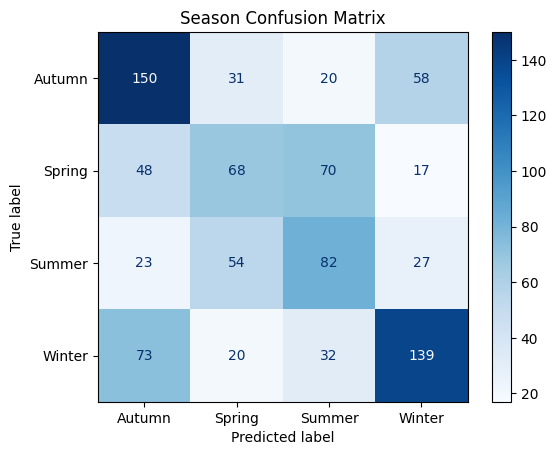

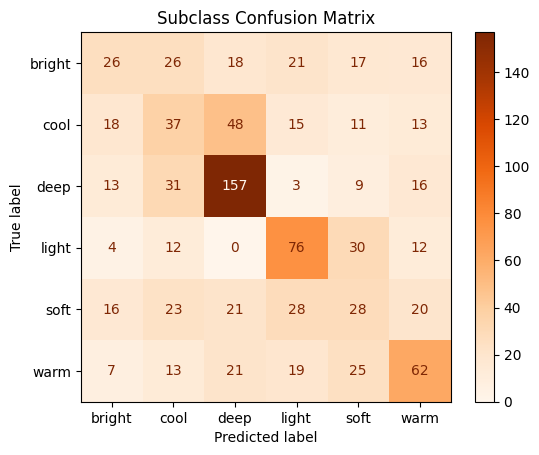

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

season_pred_labels = np.argmax(season_pred, axis=1)
subclass_pred_labels = np.argmax(subclass_pred, axis=1)

y_season_true = np.argmax(y_season_test, axis=1)
y_subclass_true = np.argmax(y_subclass_test, axis=1)

season_cm = confusion_matrix(y_season_true, season_pred_labels)
disp_season = ConfusionMatrixDisplay(confusion_matrix=season_cm, display_labels=season_le.classes_)
disp_season.plot(cmap=plt.cm.Blues)
plt.title("Season Confusion Matrix")
plt.show()

subclass_cm = confusion_matrix(y_subclass_true, subclass_pred_labels)
disp_subclass = ConfusionMatrixDisplay(confusion_matrix=subclass_cm, display_labels=subclass_le.classes_)
disp_subclass.plot(cmap=plt.cm.Oranges)
plt.title("Subclass Confusion Matrix")
plt.show()